In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

%matplotlib inline
pd.set_option('display.max_columns', 100)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def one_hot(lst, num_class=4) :
    return np.eye(num_class)[lst]

In [3]:
def making_data(csv) :
    activity = pd.read_csv(csv).drop("Unnamed: 0", axis=1)
    label = activity[["acc_id", "label"]]
    
    activity = activity[activity["label"] != "empty"]
    activity = activity.drop("label", axis=1)
    label = label[label["label"] != "empty"]
    
    activity = activity.sort_values(["acc_id","wk"])[['acc_id', 'wk', 'cnt_clear_bam', 'cnt_clear_inzone_light','cnt_clear_inzone_normal', 
                                                  'cnt_clear_inzone_skilled', 'cnt_clear_inzone_solo', 'cnt_clear_raid', 'cnt_clear_raid_light',
                                                  'cnt_dt', 'cnt_enter_bam', 'cnt_enter_inzone_light', 'cnt_enter_inzone_normal', 
                                                  'cnt_enter_inzone_skilled', 'cnt_enter_inzone_solo', 'cnt_enter_raid', 'cnt_enter_raid_light',
                                                  'cnt_use_buffitem', 'district_chat', 'duel_cnt', 'duel_win', 'faction_chat', 'game_combat_time', 
                                                  'gathering_cnt', 'get_money','guild_chat', 'item_hongmun', 'making_cnt', 'normal_chat', 
                                                  'npc_exp', 'npc_hongmun', 'party_chat', 'partybattle_cnt', 'partybattle_win', 'play_time', 
                                                  'quest_exp', 'quest_hongmun', 'whisper_chat','first_week', 'payment_amount']]
    label = label.sort_values("acc_id")
    
    label_lst = sorted(list(set([tuple(x) for x in label.values])))
    label = pd.DataFrame(label_lst, columns = ["acc_id", "label"])
    
    activity1 = activity[activity["wk"]==1].drop(["acc_id", "wk"], axis=1)
    activity2 = activity[activity["wk"]==2].drop(["acc_id", "wk"], axis=1)
    activity3 = activity[activity["wk"]==3].drop(["acc_id", "wk"], axis=1)
    activity4 = activity[activity["wk"]==4].drop(["acc_id", "wk"], axis=1)
    activity5 = activity[activity["wk"]==5].drop(["acc_id", "wk"], axis=1)
    activity6 = activity[activity["wk"]==6].drop(["acc_id", "wk"], axis=1)
    activity7 = activity[activity["wk"]==7].drop(["acc_id", "wk"], axis=1)
    activity8 = activity[activity["wk"]==8].drop(["acc_id", "wk"], axis=1)
    
    activity = np.concatenate([activity1.values, activity2.values, activity3.values, activity4.values,
                               activity5.values, activity6.values, activity7.values, activity8.values], axis=1)
    
    label_dic = {"week":0 , "month" :1, "2month":2, "retained":3}

    label2 = label.sort_values(by="acc_id")
    label2["label"] = label2["label"].map(lambda x : label_dic[x])
    
    total_lst = activity
    label_dic = label2.label.tolist()
    total_label = one_hot(label_dic)
    
    return total_lst, total_label

<br></br><br></br><br></br>

In [4]:
total_lst, total_label = making_data("OnlyExpanded.csv")

In [5]:
idx1 = len(total_lst)//5 *4

training_lst = np.array(total_lst[:idx1])
valid_lst = np.array(total_lst[idx1:])

training_label = np.array(total_label[:idx1])
valid_label = np.array(total_label[idx1:])

In [6]:
print(np.array(total_lst).shape)
print(np.array(total_label).shape)

(100000, 304)
(100000, 4)


<br></br><br></br><br></br>

# Model

In [21]:
class MLP() :
    def __init__(self, sess, name):
        self.sess = sess
        self.name = name
        
    
    def build(self, batch_size, input_dim, output_dim, num_layer, num_unit, activation) :
        with tf.variable_scope(self.name) :
            
            ## Setting ##
            # input  : ? x input_length x input_dim
            self.X = tf.placeholder(tf.float32, [None, input_dim])
            self.Y = tf.placeholder(tf.float32, [None, output_dim])
            self.learning_rate =  tf.placeholder(tf.float32)
            self.training = tf.placeholder(tf.bool)
            
            self.batch_size = batch_size
            self.output_dim = output_dim
            self.num_layer = num_layer
            self.num_unit = num_unit
            self.activation = activation
            #############
            
            
            ## MLP ##
            layer = tf.layers.dense(self.X, self.num_unit, self.activation)
            
            for idx in range(self.num_layer-2) :
                norm = tf.contrib.layers.layer_norm(layer)
                relu = tf.nn.relu(norm)
                dense = tf.layers.dense(relu, self.num_unit)
                layer = tf.layers.dropout(dense, training=self.training)
                
            layer = tf.layers.dense(layer, self.output_dim)
            #########################
            
            
            ## Classifier ##
            self.weight = tf.nn.softmax(tf.Variable(tf.random_normal([4])))+tf.ones([4])
            weight_y =  tf.reduce_sum(self.weight * self.Y, axis=1) 
            
            self.logit = layer
            self.softmax = tf.nn.softmax(self.logit)
            self.softmax_logit = tf.nn.softmax_cross_entropy_with_logits(logits=self.logit, labels=self.Y)
            self.softmax_logit_weight = self.softmax_logit * weight_y
            ################
            
            
            ## Learning ##
            self.cost = tf.reduce_sum(self.softmax_logit_weight)
            
            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope=self.name)
            with tf.control_dependencies(update_ops):
                self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
            
            self.prediction = tf.equal(tf.argmax(self.logit, 1), tf.argmax(self.Y, 1))     
            self.accuracy = tf.reduce_mean(tf.cast(self.prediction, tf.float32))    
            ##############
        
        
    def train(self, X_input, Y_input, learning_rate, training=True):
        feed_dict = {self.X: X_input, self.Y: Y_input, self.learning_rate: learning_rate, self.training: training}
        _, cost = self.sess.run([self.optimizer, self.cost], feed_dict=feed_dict)
        
        return _, cost
    
    def predict(self, X_input, training=False):
        feed_dict = {self.X: X_input, self.training: training}
        result = self.sess.run([self.logit], feed_dict=feed_dict)
            
        return result
    
    def evaluate(self, X_input, Y_input):
        size = X_input.shape[0]
            
        total_loss = 0
        total_acc = 0
            
        for idx in range(0, size, self.batch_size):
            X_batch = X_input[idx:idx + batch_size]
            Y_batch = Y_input[idx:idx + batch_size]
            feed_dict = {self.X: X_batch, self.Y: Y_batch, self.training: False}
                
            loss = self.cost
            accuracy = self.accuracy
                
            step_loss, step_acc = self.sess.run([loss, accuracy], feed_dict=feed_dict)
                
            total_loss += step_loss * X_batch.shape[0]
            total_acc += step_acc * X_batch.shape[0]
            
        total_loss /= size
        total_acc /= size
            
        return total_loss, total_acc

In [22]:
tf.reset_default_graph() 

<br></br><br></br><br></br> 

In [23]:
learning_rate1 = 0.02
learning_rate2 = 0.01
learning_rate3 = 0.005
learning_rate4 = 0.001

total_epoch = 100
batch_size = 500
input_dim = np.array(total_lst).shape[1]

In [24]:
idx = 0
model_lst = []

for num_layer in [4,6] :
    for num_unit in [256, 512] :
        for activation in [None, tf.nn.relu] :
            print(idx)
            sess = tf.Session()
            model = MLP(sess, "model{}".format(idx))
            model.build(batch_size, input_dim, 4, num_layer, num_unit, activation)
            sess.run(tf.global_variables_initializer())
            
            model_lst.append(model)
            idx +=1
            
tl_ta_vl_va_lst = [[[],[],[],[]]]*len(model_lst)
print("Ready!")

0
1
2
3
4
5
6
7
Ready!


In [25]:
print('Learning Started!')
print("")

# train my model
for epoch in range(total_epoch):
    avg_cost = [0]*len(model_lst)
    total_batch = int(len(training_lst) / batch_size)
    idx = 0
    
    if epoch == 0 :
        learning_rate = learning_rate1
    elif epoch == 10 :
        learning_rate = learning_rate2
    elif epoch == 20 :
        learning_rate = learning_rate3
    elif epoch == 80 :
        learning_rate = learning_rate4

    for i in range(total_batch):
        batch_xs, batch_ys = training_lst[idx:idx+batch_size],training_label[idx:idx+batch_size]
        
        for model_num, model in enumerate(model_lst) :
            _, c = model.train(batch_xs, batch_ys, learning_rate)
            avg_cost[model_num] += c / total_batch
        
        idx += batch_size
        if i%10 == 0 :
            print("log :", i)
            
    #train/valid cost & acc
    print("***epoch*** : ", epoch)
    for model_num, model in enumerate(model_lst) :
        train_cost, train_acc = model.evaluate(training_lst, training_label)
        valid_cost, valid_acc = model.evaluate(valid_lst, valid_label)

        tl_ta_vl_va_lst[model_num][0].append(train_cost)
        tl_ta_vl_va_lst[model_num][1].append(train_acc)
        tl_ta_vl_va_lst[model_num][2].append(valid_cost)
        tl_ta_vl_va_lst[model_num][3].append(valid_acc)

        print("-- train {:.5f}({:.1f}%), valid{:.5f}({:.1f}%)".format(train_cost, train_acc*100, valid_cost, valid_acc*100))
    
    for model in model_lst :
        print('Accuracy:', model.evaluate(valid_lst, valid_label)[1])
    for model in model_lst :
        print("Weight:", sess.run(model.weight))
    print(" ")

print("")
print('Learning Finished!')

Learning Started!

log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  0
-- train 594.61303(60.8%), valid590.35582(61.0%)
-- train 618.76161(58.5%), valid620.20883(58.3%)
-- train 625.85465(60.8%), valid621.55645(60.7%)
-- train 596.77254(60.8%), valid595.68676(61.0%)
-- train 689.31226(55.8%), valid688.07390(56.1%)
-- train 577.50131(58.5%), valid575.95497(58.4%)
-- train 788.34563(55.1%), valid774.25309(55.6%)
-- train 699.35399(49.0%), valid689.54268(49.7%)
Accuracy: 0.6102999970316887
Accuracy: 0.5832500018179416
Accuracy: 0.6070500016212463
Accuracy: 0.60954999178648
Accuracy: 0.5610000044107437
Accuracy: 0.5843999981880188
Accuracy: 0.5561500027775764
Accuracy: 0.49724999591708186
Weight: [1.4702973 1.1936939 1.321208  1.0148007]
Weight: [1.0232197 1.050801  1.8928885 1.0330907]
Weight: [1.0800753 1.1005008 1.2918491 1.5275747]
Weight: [1.0811769 1.4265966 1.2834144 1.2

log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  7
-- train 485.50107(66.7%), valid510.28987(66.5%)
-- train 495.31208(66.3%), valid523.98702(65.9%)
-- train 524.14215(65.9%), valid552.27247(65.2%)
-- train 496.49323(67.1%), valid528.08566(66.4%)
-- train 554.05835(65.4%), valid575.38329(65.3%)
-- train 528.24037(66.6%), valid554.30120(66.4%)
-- train 577.87049(67.1%), valid601.21056(66.6%)
-- train 546.25430(66.7%), valid573.78654(66.6%)
Accuracy: 0.6650499984622001
Accuracy: 0.6593499973416328
Accuracy: 0.652300001680851
Accuracy: 0.6638000026345253
Accuracy: 0.6528999999165535
Accuracy: 0.6643500000238418
Accuracy: 0.66615000218153
Accuracy: 0.6657999962568283
Weight: [1.4702973 1.1936939 1.321208  1.0148007]
Weight: [1.0232197 1.050801  1.8928885 1.0330907]
Weight: [1.0800753 1.1005008 1.2918491 1.5275747]
Weight: [1.0811769 1.4265966 1.2834144 1.208812 ]
Weight: [1.07

log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  14
-- train 469.42590(67.7%), valid515.00337(67.3%)
-- train 463.97049(68.2%), valid521.88504(67.7%)
-- train 502.57069(67.7%), valid556.93560(67.2%)
-- train 470.45845(69.3%), valid531.09450(68.2%)
-- train 489.32554(65.7%), valid517.75947(65.2%)
-- train 471.93058(66.9%), valid504.32788(66.3%)
-- train 548.93594(69.2%), valid595.37594(68.2%)
-- train 488.09164(67.5%), valid536.76295(67.0%)
Accuracy: 0.6728499993681908
Accuracy: 0.6770999997854232
Accuracy: 0.6715500026941299
Accuracy: 0.6815000012516975
Accuracy: 0.6519000038504601
Accuracy: 0.6630500003695488
Accuracy: 0.6822499990463257
Accuracy: 0.6695999965071678
Weight: [1.4702973 1.1936939 1.321208  1.0148007]
Weight: [1.0232197 1.050801  1.8928885 1.0330907]
Weight: [1.0800753 1.1005008 1.2918491 1.5275747]
Weight: [1.0811769 1.4265966 1.2834144 1.208812 ]
Weight: [

log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  21
-- train 462.17211(68.6%), valid532.98375(67.7%)
-- train 446.03696(69.6%), valid539.36931(68.3%)
-- train 491.03777(69.0%), valid594.49494(67.8%)
-- train 460.93439(70.2%), valid578.19485(68.8%)
-- train 428.18246(68.2%), valid465.18635(67.8%)
-- train 438.57761(68.0%), valid497.56515(67.1%)
-- train 474.74825(70.2%), valid544.59234(68.9%)
-- train 470.36045(68.5%), valid544.96393(67.4%)
Accuracy: 0.6771999970078468
Accuracy: 0.6825500011444092
Accuracy: 0.6783999994397163
Accuracy: 0.6875499948859215
Accuracy: 0.6783999964594841
Accuracy: 0.6712499961256981
Accuracy: 0.689199997484684
Accuracy: 0.6736499980092049
Weight: [1.4702973 1.1936939 1.321208  1.0148007]
Weight: [1.0232197 1.050801  1.8928885 1.0330907]
Weight: [1.0800753 1.1005008 1.2918491 1.5275747]
Weight: [1.0811769 1.4265966 1.2834144 1.208812 ]
Weight: [1

log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  28
-- train 444.04558(68.7%), valid535.79972(67.3%)
-- train 440.66011(70.2%), valid581.36940(68.3%)
-- train 479.04607(68.1%), valid627.49389(66.5%)
-- train 465.76725(70.5%), valid641.90483(68.5%)
-- train 416.76957(68.0%), valid467.28551(67.2%)
-- train 418.22447(68.4%), valid488.33816(67.4%)
-- train 464.43879(70.8%), valid557.98348(69.1%)
-- train 485.58581(69.0%), valid586.42070(67.3%)
Accuracy: 0.6732999950647354
Accuracy: 0.6830499976873398
Accuracy: 0.6645000025629997
Accuracy: 0.6850000008940696
Accuracy: 0.6715499982237816
Accuracy: 0.6736499965190887
Accuracy: 0.6905500009655953
Accuracy: 0.67325000166893
Weight: [1.4702973 1.1936939 1.321208  1.0148007]
Weight: [1.0232197 1.050801  1.8928885 1.0330907]
Weight: [1.0800753 1.1005008 1.2918491 1.5275747]
Weight: [1.0811769 1.4265966 1.2834144 1.208812 ]
Weight: [1.

log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  35
-- train 434.84455(69.1%), valid552.50838(67.5%)
-- train 433.02034(71.0%), valid627.16467(68.2%)
-- train 472.61020(69.5%), valid668.31072(67.2%)
-- train 432.51063(71.7%), valid660.06153(68.9%)
-- train 404.95771(68.0%), valid454.25419(67.0%)
-- train 409.71243(68.2%), valid490.44398(66.8%)
-- train 463.46828(71.3%), valid575.00093(69.3%)
-- train 449.38328(69.2%), valid575.96063(67.1%)
Accuracy: 0.6753000006079674
Accuracy: 0.6824000000953674
Accuracy: 0.6716000005602837
Accuracy: 0.6886000022292137
Accuracy: 0.6700999990105629
Accuracy: 0.6677000015974045
Accuracy: 0.6929499968886376
Accuracy: 0.6705000028014183
Weight: [1.4702973 1.1936939 1.321208  1.0148007]
Weight: [1.0232197 1.050801  1.8928885 1.0330907]
Weight: [1.0800753 1.1005008 1.2918491 1.5275747]
Weight: [1.0811769 1.4265966 1.2834144 1.208812 ]
Weight: [

log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  42
-- train 409.32850(70.1%), valid548.60119(68.2%)
-- train 422.55392(71.1%), valid654.27483(68.3%)
-- train 461.38078(69.0%), valid725.80236(66.2%)
-- train 431.95750(72.1%), valid733.24789(68.5%)
-- train 395.96118(68.3%), valid457.54411(67.0%)
-- train 414.77878(68.9%), valid512.97847(67.2%)
-- train 433.89535(72.1%), valid574.74073(69.3%)
-- train 432.51479(70.2%), valid602.21191(67.3%)
Accuracy: 0.6821499928832054
Accuracy: 0.6826499983668327
Accuracy: 0.6619499996304512
Accuracy: 0.6854999974370003
Accuracy: 0.669599997997284
Accuracy: 0.671749995648861
Accuracy: 0.6926500022411346
Accuracy: 0.6729999974370002
Weight: [1.4702973 1.1936939 1.321208  1.0148007]
Weight: [1.0232197 1.050801  1.8928885 1.0330907]
Weight: [1.0800753 1.1005008 1.2918491 1.5275747]
Weight: [1.0811769 1.4265966 1.2834144 1.208812 ]
Weight: [1.

log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  49
-- train 415.09907(70.1%), valid588.30162(67.7%)
-- train 423.66595(71.7%), valid695.08627(68.3%)
-- train 448.02901(70.0%), valid770.74111(66.9%)
-- train 438.57680(72.2%), valid808.18540(68.4%)
-- train 386.87977(68.5%), valid451.22825(66.9%)
-- train 403.51274(68.8%), valid520.20440(66.9%)
-- train 413.84738(72.5%), valid578.38382(69.2%)
-- train 406.44801(70.7%), valid581.25800(67.4%)
Accuracy: 0.6774499982595443
Accuracy: 0.6827499970793725
Accuracy: 0.6690500006079674
Accuracy: 0.6842999950051307
Accuracy: 0.6691000029444695
Accuracy: 0.6693999975919723
Accuracy: 0.6924999952316284
Accuracy: 0.6744999974966049
Weight: [1.4702973 1.1936939 1.321208  1.0148007]
Weight: [1.0232197 1.050801  1.8928885 1.0330907]
Weight: [1.0800753 1.1005008 1.2918491 1.5275747]
Weight: [1.0811769 1.4265966 1.2834144 1.208812 ]
Weight: [

log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  56
-- train 399.78332(70.9%), valid594.43780(68.2%)
-- train 413.86818(71.7%), valid722.12931(68.2%)
-- train 433.46890(70.2%), valid803.58954(66.4%)
-- train 424.79528(73.1%), valid863.69176(69.0%)
-- train 387.36542(68.9%), valid466.45736(67.2%)
-- train 395.08879(69.8%), valid546.77278(67.1%)
-- train 413.97083(72.8%), valid591.21364(69.1%)
-- train 397.18423(71.7%), valid614.85052(68.1%)
Accuracy: 0.6819999992847443
Accuracy: 0.6816999971866607
Accuracy: 0.6640000030398369
Accuracy: 0.6902999997138977
Accuracy: 0.6722999975085259
Accuracy: 0.6706000000238419
Accuracy: 0.690549997985363
Accuracy: 0.680649995803833
Weight: [1.4702973 1.1936939 1.321208  1.0148007]
Weight: [1.0232197 1.050801  1.8928885 1.0330907]
Weight: [1.0800753 1.1005008 1.2918491 1.5275747]
Weight: [1.0811769 1.4265966 1.2834144 1.208812 ]
Weight: [1.

log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  63
-- train 386.29797(71.0%), valid595.85751(67.8%)
-- train 397.71191(72.7%), valid755.74191(68.3%)
-- train 436.86546(70.5%), valid874.21327(66.5%)
-- train 407.13245(73.6%), valid862.30332(68.8%)
-- train 391.91649(68.7%), valid483.07282(66.3%)
-- train 391.45683(69.9%), valid562.63752(67.1%)
-- train 406.04114(73.0%), valid624.68668(68.8%)
-- train 398.72329(71.5%), valid613.17479(68.1%)
Accuracy: 0.6775499999523162
Accuracy: 0.6827499970793725
Accuracy: 0.6648000001907348
Accuracy: 0.6879999980330467
Accuracy: 0.6630000025033951
Accuracy: 0.670550000667572
Accuracy: 0.6877500027418136
Accuracy: 0.6808499976992607
Weight: [1.4702973 1.1936939 1.321208  1.0148007]
Weight: [1.0232197 1.050801  1.8928885 1.0330907]
Weight: [1.0800753 1.1005008 1.2918491 1.5275747]
Weight: [1.0811769 1.4265966 1.2834144 1.208812 ]
Weight: [1

log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  70
-- train 394.04495(71.4%), valid644.37193(68.1%)
-- train 405.26136(71.4%), valid758.77836(67.1%)
-- train 418.78454(71.4%), valid923.78314(67.3%)
-- train 413.78271(73.8%), valid931.03298(69.1%)
-- train 382.47120(69.5%), valid489.51387(67.3%)
-- train 388.69485(70.3%), valid583.63766(67.2%)
-- train 404.15108(73.3%), valid646.99873(69.0%)
-- train 392.43018(71.7%), valid648.18990(67.7%)
Accuracy: 0.680999992787838
Accuracy: 0.670999999344349
Accuracy: 0.673250000178814
Accuracy: 0.6913500010967255
Accuracy: 0.6729499965906143
Accuracy: 0.672350001335144
Accuracy: 0.6900499984622002
Accuracy: 0.676850001513958
Weight: [1.4702973 1.1936939 1.321208  1.0148007]
Weight: [1.0232197 1.050801  1.8928885 1.0330907]
Weight: [1.0800753 1.1005008 1.2918491 1.5275747]
Weight: [1.0811769 1.4265966 1.2834144 1.208812 ]
Weight: [1.070

log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  77
-- train 408.02772(70.9%), valid678.61520(67.4%)
-- train 418.84662(72.2%), valid824.02109(67.4%)
-- train 418.92774(71.8%), valid931.93696(67.3%)
-- train 441.03396(73.4%), valid966.35327(68.7%)
-- train 386.77646(70.1%), valid501.94332(67.4%)
-- train 392.49331(71.1%), valid612.43444(67.8%)
-- train 393.14189(74.1%), valid651.98953(69.3%)
-- train 387.21015(72.5%), valid697.82548(67.9%)
Accuracy: 0.6742499962449073
Accuracy: 0.674150002002716
Accuracy: 0.6730999991297721
Accuracy: 0.6868000000715255
Accuracy: 0.6743499994277954
Accuracy: 0.6778499945998192
Accuracy: 0.6928500026464463
Accuracy: 0.6787499994039535
Weight: [1.4702973 1.1936939 1.321208  1.0148007]
Weight: [1.0232197 1.050801  1.8928885 1.0330907]
Weight: [1.0800753 1.1005008 1.2918491 1.5275747]
Weight: [1.0811769 1.4265966 1.2834144 1.208812 ]
Weight: [1

log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  84
-- train 367.50145(73.6%), valid707.31418(68.6%)
-- train 388.06762(74.3%), valid890.46983(68.5%)
-- train 376.54503(74.4%), valid1084.21822(69.1%)
-- train 376.17765(75.4%), valid1083.63147(69.5%)
-- train 372.11521(71.7%), valid496.93707(68.8%)
-- train 386.25500(71.9%), valid626.04144(68.0%)
-- train 367.66871(74.8%), valid678.89229(69.5%)
-- train 375.58749(74.3%), valid742.41562(68.8%)
Accuracy: 0.6864499986171723
Accuracy: 0.6848000004887581
Accuracy: 0.6908000037074089
Accuracy: 0.6945500016212464
Accuracy: 0.6882499933242798
Accuracy: 0.6795999959111214
Accuracy: 0.6949000015854836
Accuracy: 0.6884499996900558
Weight: [1.4702973 1.1936939 1.321208  1.0148007]
Weight: [1.0232197 1.050801  1.8928885 1.0330907]
Weight: [1.0800753 1.1005008 1.2918491 1.5275747]
Weight: [1.0811769 1.4265966 1.2834144 1.208812 ]
Weight:

log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  91
-- train 364.05681(73.8%), valid740.93010(68.9%)
-- train 388.30092(74.5%), valid965.20838(68.6%)
-- train 378.27451(74.1%), valid1183.58251(68.3%)
-- train 372.59931(75.8%), valid1184.93097(69.6%)
-- train 370.60719(72.5%), valid504.53010(69.2%)
-- train 388.15576(71.7%), valid643.64818(67.7%)
-- train 362.55249(74.9%), valid694.15461(69.4%)
-- train 372.86876(74.5%), valid752.67342(68.8%)
Accuracy: 0.6888999983668327
Accuracy: 0.6859999999403954
Accuracy: 0.6825499966740608
Accuracy: 0.6958000019192696
Accuracy: 0.6919499963521958
Accuracy: 0.6774999976158143
Accuracy: 0.6942500010132789
Accuracy: 0.6879999980330467
Weight: [1.4702973 1.1936939 1.321208  1.0148007]
Weight: [1.0232197 1.050801  1.8928885 1.0330907]
Weight: [1.0800753 1.1005008 1.2918491 1.5275747]
Weight: [1.0811769 1.4265966 1.2834144 1.208812 ]
Weight:

log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  98
-- train 358.06459(74.0%), valid773.21636(68.8%)
-- train 384.51496(74.6%), valid1001.15076(68.5%)
-- train 382.27061(74.6%), valid1271.38911(68.7%)
-- train 375.11190(75.8%), valid1290.31451(69.7%)
-- train 366.30169(71.9%), valid513.76825(68.7%)
-- train 389.35657(72.2%), valid662.60971(68.0%)
-- train 363.32936(75.3%), valid715.43647(69.4%)
-- train 374.88728(74.3%), valid784.81915(68.7%)
Accuracy: 0.6884499967098237
Accuracy: 0.6852499961853027
Accuracy: 0.6870999991893768
Accuracy: 0.6968000009655952
Accuracy: 0.686700002849102
Accuracy: 0.6795999988913536
Accuracy: 0.6943500012159347
Accuracy: 0.6869499966502189
Weight: [1.4702973 1.1936939 1.321208  1.0148007]
Weight: [1.0232197 1.050801  1.8928885 1.0330907]
Weight: [1.0800753 1.1005008 1.2918491 1.5275747]
Weight: [1.0811769 1.4265966 1.2834144 1.208812 ]
Weight:

 <br></br><br></br><br></br> 

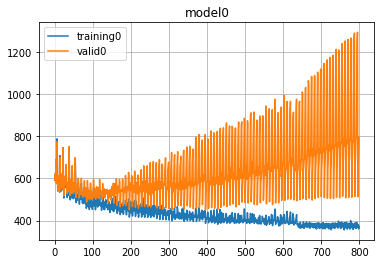

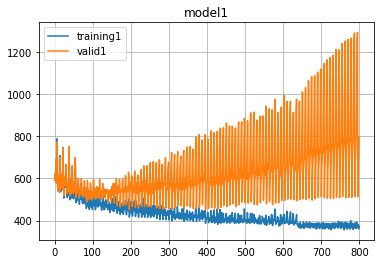

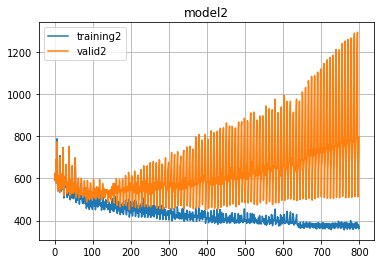

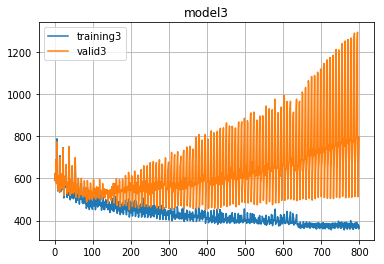

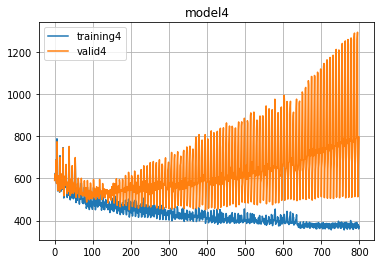

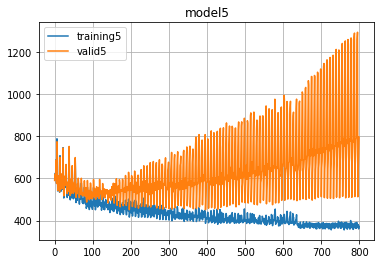

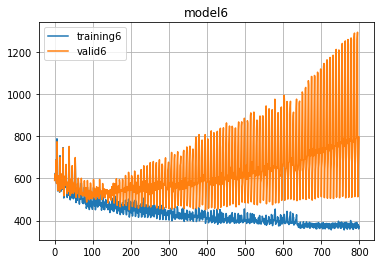

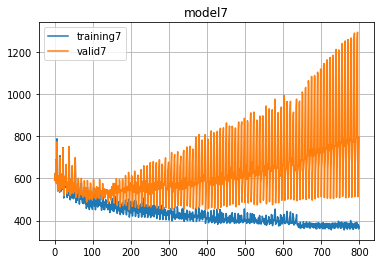

In [26]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][0], label='training'+str(idx))
    plt.plot(tl_ta_vl_va_lst[idx][2], label='valid'+str(idx))
    plt.title("model"+str(idx))
    plt.grid("on")
    plt.legend()
    plt.show()

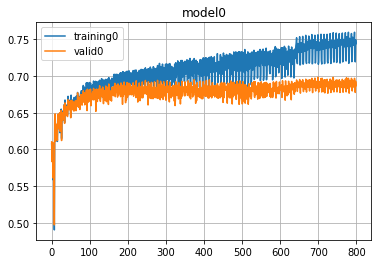

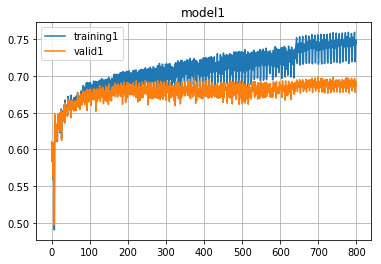

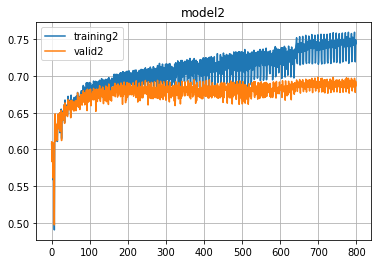

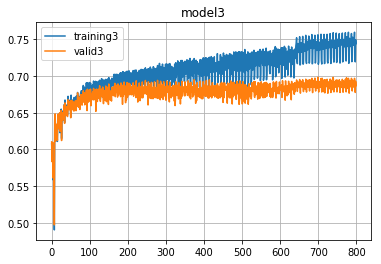

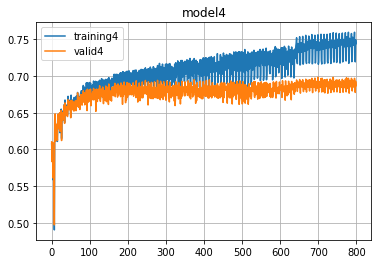

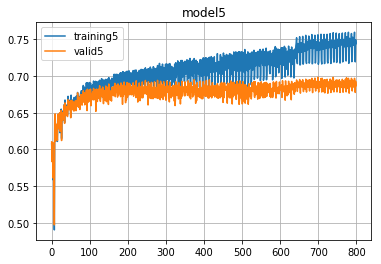

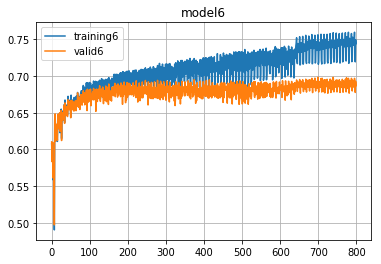

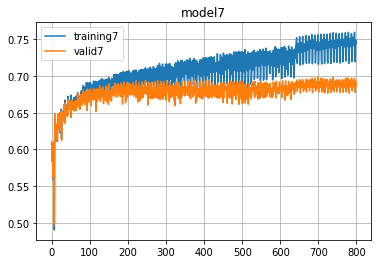

In [27]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][1], label='training'+str(idx))
    plt.plot(tl_ta_vl_va_lst[idx][3], label='valid'+str(idx))
    plt.title("model"+str(idx))
    plt.grid("on")
    plt.legend()
    plt.show()

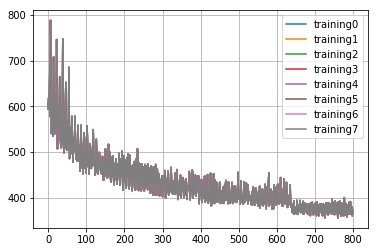

In [28]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][0], label='training'+str(idx))
    
plt.grid("on")
plt.legend()
plt.show()

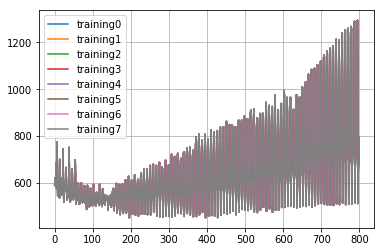

In [29]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][2], label='training'+str(idx))
    
plt.grid("on")
plt.legend()
plt.show()

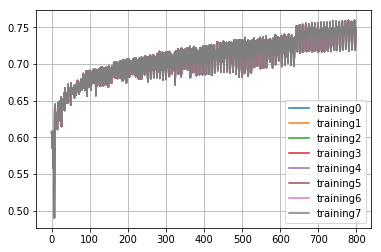

In [30]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][1], label='training'+str(idx))
    
plt.grid("on")
plt.legend()
plt.show()

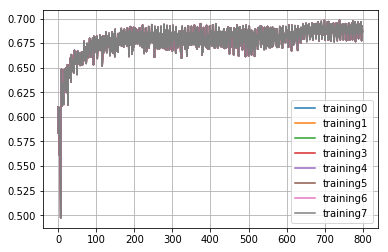

In [31]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][3], label='training'+str(idx))
    
plt.grid("on")
plt.legend()
plt.show()

<br></br><br></br><br></br>  

In [ ]:
#tf.reset_default_graph() 

In [364]:
saver = tf.train.Saver()

for idx, model in enumerate(model_lst) :
    saver.save(model.sess, './model/MLP_default_model_{}'.format(idx))

print("Saved!")

'./advanced_RNN/original_user_vector/original'

<br></br><br></br><br></br>

# Test

In [32]:
def making_data(csv) :
    activity = pd.read_csv(csv).drop("Unnamed: 0", axis=1)
    
    activity = activity[activity["label"] == "empty"]
    activity = activity.drop("label", axis=1)
    
    activity = activity.sort_values(["acc_id","wk"])[['acc_id', 'wk', 'cnt_clear_bam', 'cnt_clear_inzone_light','cnt_clear_inzone_normal', 
                                                  'cnt_clear_inzone_skilled', 'cnt_clear_inzone_solo', 'cnt_clear_raid', 'cnt_clear_raid_light',
                                                  'cnt_dt', 'cnt_enter_bam', 'cnt_enter_inzone_light', 'cnt_enter_inzone_normal', 
                                                  'cnt_enter_inzone_skilled', 'cnt_enter_inzone_solo', 'cnt_enter_raid', 'cnt_enter_raid_light',
                                                  'cnt_use_buffitem', 'district_chat', 'duel_cnt', 'duel_win', 'faction_chat', 'game_combat_time', 
                                                  'gathering_cnt', 'get_money','guild_chat', 'item_hongmun', 'making_cnt', 'normal_chat', 
                                                  'npc_exp', 'npc_hongmun', 'party_chat', 'partybattle_cnt', 'partybattle_win', 'play_time', 
                                                  'quest_exp', 'quest_hongmun', 'whisper_chat','first_week', 'payment_amount']]
    
    activity1 = activity[activity["wk"]==1].drop(["acc_id", "wk"], axis=1)
    activity2 = activity[activity["wk"]==2].drop(["acc_id", "wk"], axis=1)
    activity3 = activity[activity["wk"]==3].drop(["acc_id", "wk"], axis=1)
    activity4 = activity[activity["wk"]==4].drop(["acc_id", "wk"], axis=1)
    activity5 = activity[activity["wk"]==5].drop(["acc_id", "wk"], axis=1)
    activity6 = activity[activity["wk"]==6].drop(["acc_id", "wk"], axis=1)
    activity7 = activity[activity["wk"]==7].drop(["acc_id", "wk"], axis=1)
    activity8 = activity[activity["wk"]==8].drop(["acc_id", "wk"], axis=1)
    
    label = activity["acc_id"].values
    activity = np.concatenate([activity1.values, activity2.values, activity3.values, activity4.values,
                               activity5.values, activity6.values, activity7.values, activity8.values], axis=1)

    total_lst = activity
    return total_lst, label

In [33]:
test_data, test_acc_id = making_data("OnlyExpanded.csv")

In [34]:
print(test_data.shape)

(40000, 304)


<br></br><br></br><br></br> 

# Predict

In [59]:
result = []
for model in model_lst :
    result.append(np.argmax(model.predict(test_data), axis=2)) 
    
result = list(map(lambda x : x.tolist()[0], result))
for r_lst in result :
    print("week: {}, month: {}, 2month: {}, retained: {}".format(r_lst.count(0), r_lst.count(1), r_lst.count(2), r_lst.count(3)))

In [66]:
label_df = pd.DataFrame(sorted(list(set(list(test_acc_id))))).rename(columns = {0 : "acc_id"})
result_df = pd.DataFrame(result).T

,0,1,2,3,4,5,6,7
0,2,2,2,2,2,2,2,2
1,0,0,0,0,0,0,0,0
2,2,2,2,2,2,2,2,2
3,2,2,2,2,2,2,2,2
4,2,2,2,2,2,3,3,3


In [78]:
result_df2 = pd.concat([label_df, result_df], axis=1)
result_df2.head()

,acc_id,0,1,2,3,4,5,6,7
0,0002a56a036206aea3a6c6ebc985df4a2d1987b562e7f0...,2,2,2,2,2,2,2,2
1,0003bfdebe2b5d46217e8fa5ab0f33cf186fb558435f20...,0,0,0,0,0,0,0,0
2,0008f5dce798aaac3f0b05f8a4269cf2052c9b8c5bd911...,2,2,2,2,2,2,2,2
3,000cacd86bddabebef813351455304df5493cd71a3d1d2...,2,2,2,2,2,2,2,2
4,000ef0765596ac6a6a0a62654895e4673825b6102c7f41...,2,2,2,2,2,3,3,3
